In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib.ticker import NullFormatter
import pandas as pd
import os
import torch
%matplotlib inline
import time

from matplotlib import rc
matplotlib.rcParams.update({'font.size': 15})
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
# rc('text', usetex=True) #can't plot some basic text..?

In [5]:
class OptExperimentParser(object):
    """
    This takes in one experiment folder and parses the args.txt and the 
    values of all the runs in that folder.
    NaNs are kept so they can plotted as desired.
    Parsing much slower for experiments stored on mounted folder. 
    This is for experiments that learn lr and/or mom and/or wd
    """
    def __init__(self, exp_folder):
        self.exp_folder = exp_folder
        self.parse_args()
        self.parse_runs()
        self.parse_grads()
    
    def parse_args(self):
        args_path = os.path.join(self.exp_folder, 'args.txt')
        df = pd.read_csv(args_path, sep='\t', header=None, usecols=[0,1], names=['keys', 'values'])
        self.args = {k.strip():v.strip() for k,v in zip(df['keys'], df['values'])}
    
    def parse_runs(self, max_n_runs=1000, drop_last=True):       
        self.runs = {}
        for i in range(max_n_runs):
            file_path = os.path.join(self.exp_folder, 'run{}'.format(i), 'log.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if not drop_last or int(df['global_step'].iat[-1]) == int(self.args['n_epochs_per_run']) -1:
                    self.runs['run{}'.format(i)] = df
    
    def parse_grads(self):
        """
        appends to self.runs dfs
        To make things consistent, this will only add as many epochs per run as 
        log_freq specified, even though all grads are saved for each epoch.
        Note that when raw=last value only and smooth=all greed steps, it's possible
        raw and smooth don't have the same sign. 
        """
        checkpoint_path = os.path.join(self.exp_folder, 'checkpoint.pth.tar')
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        all_lr_raw_grads = checkpoint['all_lr_raw_grads'] if 'all_lr_raw_grads' in checkpoint else None
        all_lr_smooth_grads = checkpoint['all_lr_smooth_grads'] if 'all_lr_smooth_grads' in checkpoint else None
        all_mom_raw_grads = checkpoint['all_mom_raw_grads'] if 'all_mom_raw_grads' in checkpoint else None
        all_mom_smooth_grads = checkpoint['all_mom_smooth_grads'] if 'all_mom_smooth_grads' in checkpoint else None
        all_wd_raw_grads = checkpoint['all_wd_raw_grads'] if 'all_wd_raw_grads' in checkpoint else None
        all_wd_smooth_grads = checkpoint['all_wd_smooth_grads'] if 'all_wd_smooth_grads' in checkpoint else None
        
        
        for run in self.runs.keys():
            run_idx = int(run.replace('run', ''))
            
            if all_lr_raw_grads is not None:
                inner_lr_grads = all_lr_raw_grads[run_idx]
                inner_lr_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    lr_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    lr = float(inner_lr_grads[lr_index])
                    inner_lr_grads_epoch.append(lr)
                self.runs[run]['TRAIN/raw_lr_grads'] = inner_lr_grads_epoch
            
            if all_lr_smooth_grads is not None:
                inner_lr_grads = all_lr_smooth_grads[run_idx]
                inner_lr_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    lr_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    lr = float(inner_lr_grads[lr_index])
                    inner_lr_grads_epoch.append(lr)
                self.runs[run]['TRAIN/smooth_lr_grads'] = inner_lr_grads_epoch
            

            if all_mom_raw_grads is not None:
                inner_mom_grads = all_mom_raw_grads[run_idx]
                inner_mom_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    mom_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    mom = float(inner_mom_grads[mom_index])
                    inner_mom_grads_epoch.append(mom)
                self.runs[run]['TRAIN/raw_mom_grads'] = inner_mom_grads_epoch
            
            if all_mom_smooth_grads is not None:
                inner_mom_grads = all_mom_smooth_grads[run_idx]
                inner_mom_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    mom_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    mom = float(inner_mom_grads[mom_index])
                    inner_mom_grads_epoch.append(mom)
                self.runs[run]['TRAIN/smooth_mom_grads'] = inner_mom_grads_epoch
            
            
            if all_wd_raw_grads is not None:
                inner_wd_grads = all_wd_raw_grads[run_idx]
                inner_wd_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    wd_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    wd = float(inner_wd_grads[wd_index])
                    inner_wd_grads_epoch.append(wd)
                self.runs[run]['TRAIN/raw_wd_grads'] = inner_wd_grads_epoch
            
            
            if all_wd_smooth_grads is not None:
                inner_wd_grads = all_wd_smooth_grads[run_idx]
                inner_wd_grads_epoch = []

                for epoch in self.runs[run]['global_step']:
                    wd_index = int(epoch * int(self.args['n_hypers']) / int(self.args['n_epochs_per_run']))
                    wd = float(inner_wd_grads[wd_index])
                    inner_wd_grads_epoch.append(wd)
                self.runs[run]['TRAIN/smooth_wd_grads'] = inner_wd_grads_epoch
        
    

In [14]:

def parse_experiment_names(name_list):
    """
    TODO: doesn't take into account location so duplicate keys are removed
    e.g. inner and outer momentum 
    """
    commons = []
    parsed_name_list = [name.split('_') for name in name_list]
    clean_names = [name.split('_') for name in name_list]
    
    for key in parsed_name_list[0]:
        if (all([key in names for names in parsed_name_list])):
            commons.append(key)
    
    for idx, parsed_name in enumerate(parsed_name_list):
        for k in parsed_name:
            if k in commons:
                clean_names[idx].remove(k)
    
    return '_'.join(commons), ['_'.join(el) for el in clean_names]


def plot_mom_grad_test(master_folder, raw_grads_range=None):
    
    ## Parse
    experiments = {}
    experiment_names = []
    for exp_name in os.listdir(master_folder):
        if 'FSL' in exp_name:
            exp_path = os.path.join(master_folder, exp_name)
            experiments[exp_name] = OptExperimentParser(exp_path)
    n_experiments = len(experiments)
    if n_experiments == 0: raise ValueError
    
    ## Plot
    fig = plt.figure(figsize=(20,7*n_experiments))
    grid_params = {'axis':'y', 'linestyle': '--', 'linewidth': 1, 'alpha':0.5}
    i = 1

    for exp_key, exp in sorted(experiments.items()):
        experiment_names.append(exp_key)
        runs = exp.runs
        n_epochs = int(exp.args['n_epochs_per_run'])
        ax1 = fig.add_subplot(n_experiments, 4, i)
        ax2 = fig.add_subplot(n_experiments, 4, i+1)
        ax3 = fig.add_subplot(n_experiments, 4, i+2)
        ax4 = fig.add_subplot(n_experiments, 4, i+3)
        i += 4

        n_runs = len(runs.keys()) #total # of runs so far

        first_test_acc, last_test_acc, best_test_acc, best_run_key = 0, 0, 0, 0


        for run_idx, (run_key, run_data) in enumerate(runs.items()): # TODO: make sure this is sorted explicitely
            color = plt.cm.rainbow((run_idx+1)/n_runs)
            ax1.grid(**grid_params)
            ax2.grid(**grid_params)
            ax3.grid(**grid_params)
            ax4.grid(**grid_params)
            alpha = 0.8 #(run_idx+1)/n_runs if run_idx>0 else 0.8
            linewidth = 2 if (run_idx+1)==n_runs or run_idx==0 else 1
            ax1.plot(run_data['global_step'], run_data['TRAIN/inner_mom'], color=color, alpha=alpha, linewidth=linewidth)
            ax2.plot(run_data['global_step'], run_data['TRAIN/raw_mom_grads'], color=color, alpha=alpha, linewidth=linewidth)
            ax3.plot(run_data['global_step'], run_data['TRAIN/smooth_mom_grads'], color=color, alpha=alpha, linewidth=linewidth)
            ax4.plot(run_data['global_step'], run_data['TEST/acc'], color=color, alpha=alpha, linewidth=linewidth)
            if run_idx == 0: first_test_acc = float(run_data['TEST/acc'].iat[-1])
            if int(run_data['global_step'].iat[-1]) == n_epochs-1: last_test_acc = float(run_data['TEST/acc'].iat[-1])
            if float(run_data['TEST/acc'].iat[-1]) > best_test_acc: 
                best_test_acc = float(run_data['TEST/acc'].iat[-1])
                best_run_key = run_key
            if raw_grads_range is not None: ax2.set_ylim(*raw_grads_range)
            

        ax4.text(0.5, 0.3, 'end: {:02.2f}% ({})'.format(last_test_acc, run_key), fontsize=20, transform=ax4.transAxes)
        ax4.text(0.5, 0.2, 'best: {:02.2f}% ({})'.format(best_test_acc, best_run_key), fontsize=20, transform=ax4.transAxes)
        ax4.text(0.5, 0.1, 'start: {:02.2f}%'.format(first_test_acc), fontsize=20, transform=ax4.transAxes)
        
    common_keys, unique_keys = parse_experiment_names(experiment_names)
    print(common_keys, '\n')
    all_axes = fig.get_axes()
    for idx,key in enumerate(unique_keys): 
        print('\t',key)
        all_axes[idx*4].set_ylabel(key)
    print('\n')

    


-------------------------------------------

In [7]:
cdt_logs = '/home/paul/CDT_logs/'
dice_logs = '/home/paul/DICE_logs/'
local_logs = '/home/paul/LOCAL_logs/GreedyGrad/Scheduler_learning/FullHorizon'

## LOCAL LOGS

FSL_CIFAR10_WRN-10-1_nBN_ReLU_nr40_nepr40_nhyper4_mpc0.1_tbs512_step_iSGD_wd0.0005_olr0.1_oSGD_m0.1_S1 

	 ilr0.2_mom0.0
	 ilr0.2_mom0.99
	 ilr0.2_mom0.9
	 ilr0.4_mom0.2




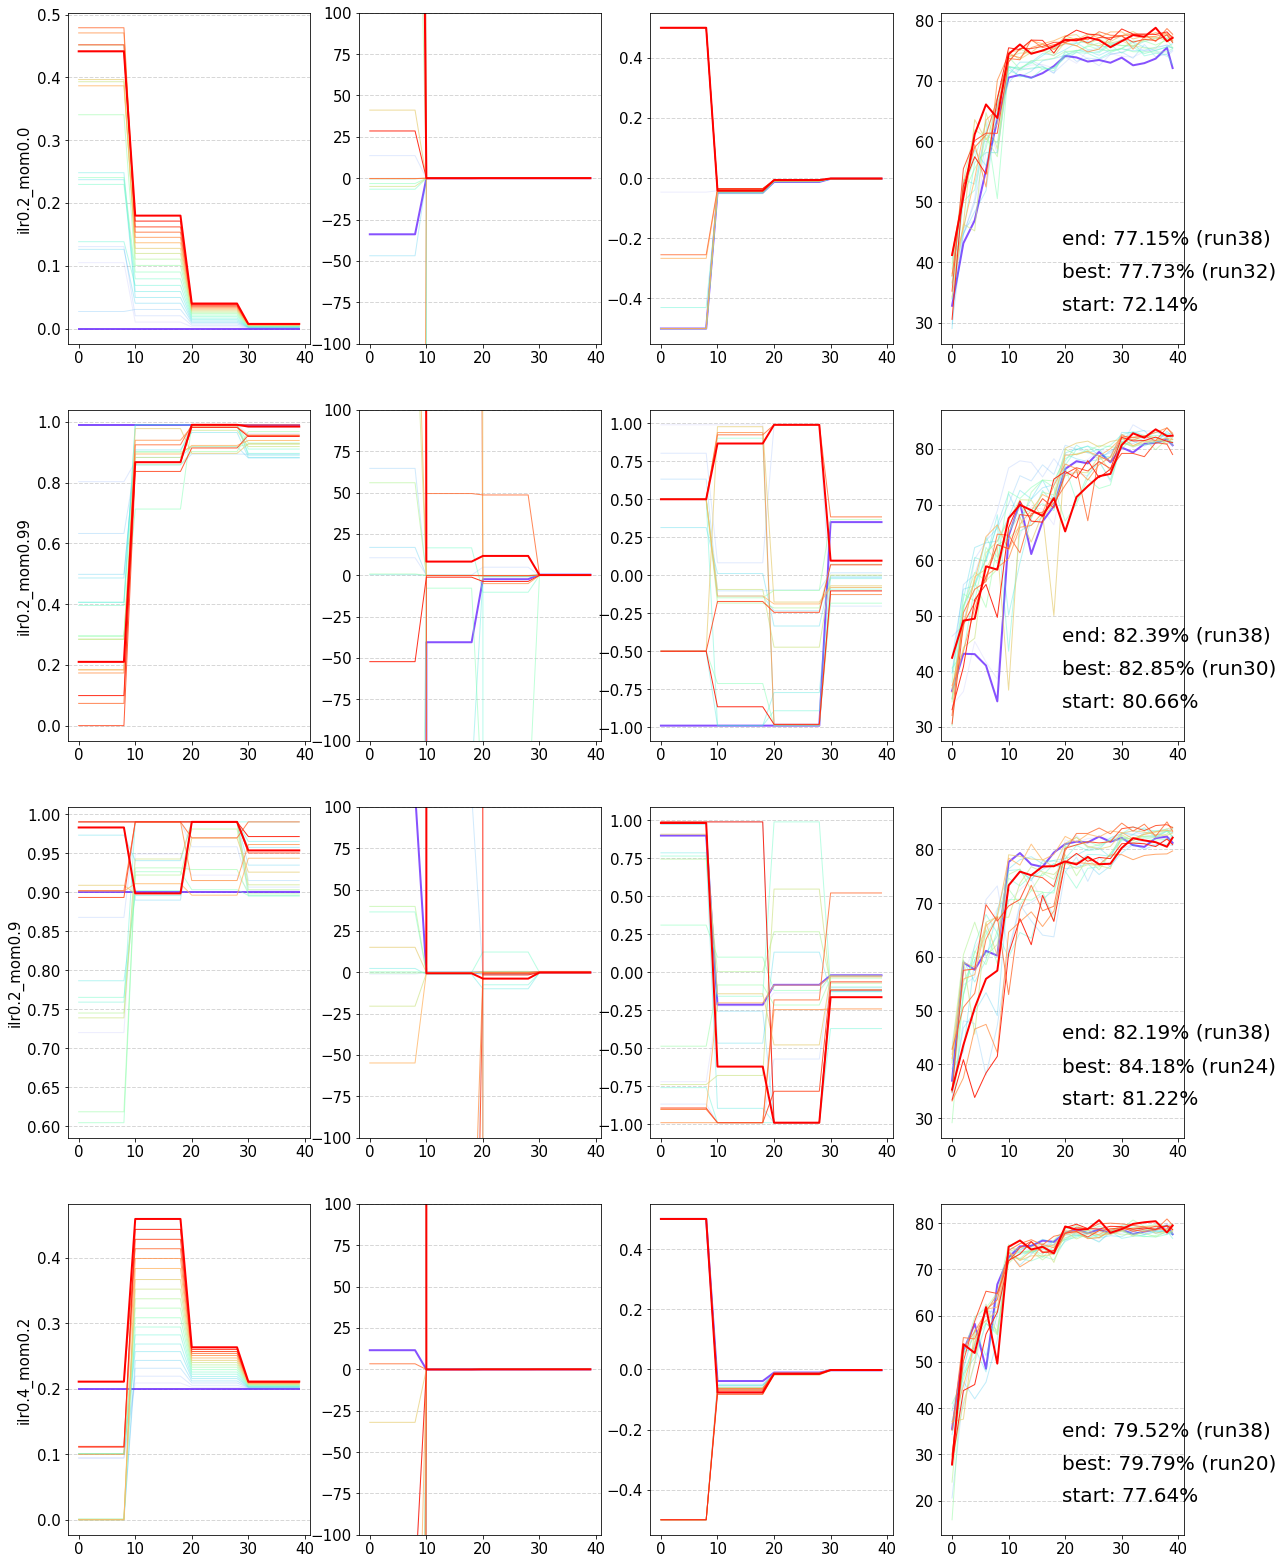

In [9]:
master_folder = local_logs + '/mom/' + 'run0_init'
plot_mom_grad_test(master_folder, raw_grads_range=(-100, 100))

FSL_CIFAR10_WRN-16-1_nBN_ReLU_nr40_nepr50_nhyper5_mpc0.1_tbs512_ilr0.1_step_iSGD_wd0.0005_olr0.1_oSGD_m0.1_HZclamp10.0_gradsclamp5.0_S1 

	 mom0.0
	 mom0.5
	 mom1.0




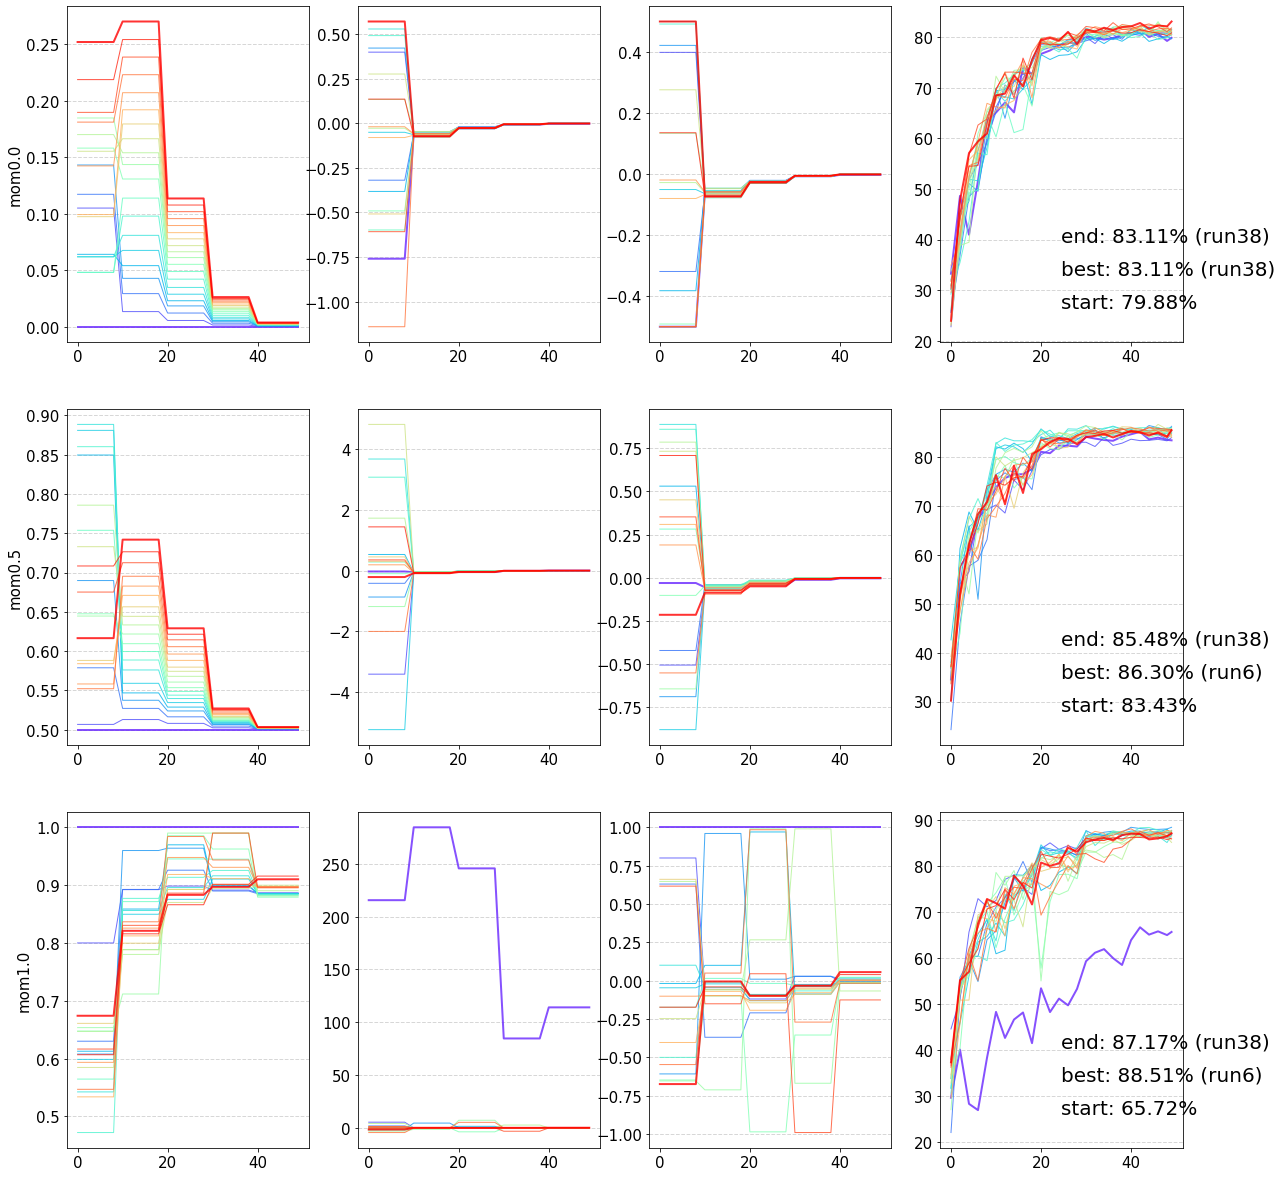

In [16]:
master_folder = local_logs + '/mom/' + 'run2_ilr0.1_small_+does_learn_and_improve_accfrom_0.0_0.5_or_1_but_too_slowly_from_0.0_+grads_very_stable_from mom0.0'
plot_mom_grad_test(master_folder)#, raw_grads_range=(-1,1))

FSL_CIFAR10_WRN-16-1_nBN_ReLU_nr40_nepr50_nhyper5_mpc0.1_tbs512_ilr0.1_step_iSGD_mom0.9_wd0.0005_olr0.1_oSGD_m0.1_HZclamp10.0_gradsclamp5.0_S1 

	 1stord50
	 zeroC




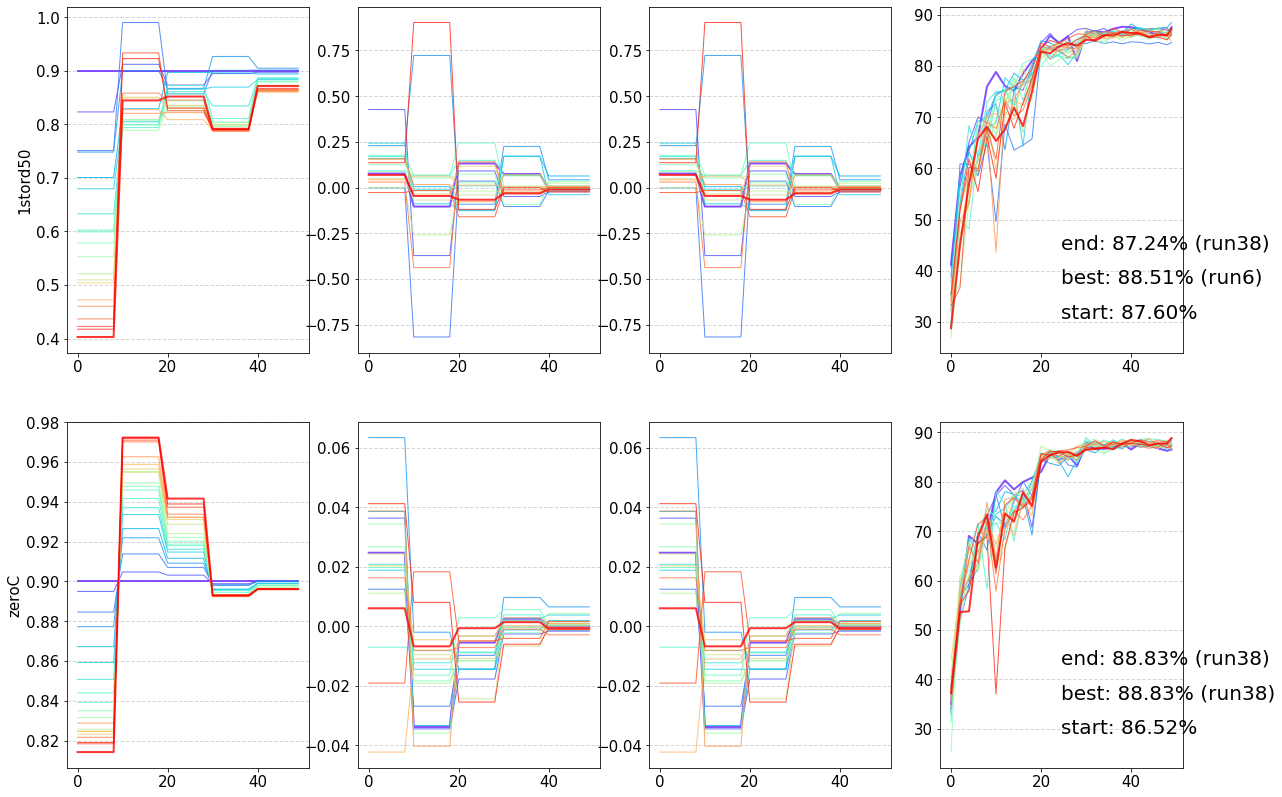

In [18]:
master_folder = local_logs + '/mom/' + 'run4_intermediates'
plot_mom_grad_test(master_folder)#, raw_grads_range=(-1,1))